In [1]:
pip install numpy pandas matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('./data/train.csv')

In [4]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [6]:
def ReLU(Z):
    # ReLU function
    # Return the maximum of 0 and Z
    # In other words:
    # If Z is positive, return Z
    # If Z is negative, return 0
    return np.maximum(0, Z)

def ReLU_deriv(Z):
    # Derivative of ReLU function
    # Return 1 if Z is positive, 0 otherwise
    return Z > 0

def softmax(Z):
    # Softmax function
    # Return the exponential of Z, divided by the sum of the exponential of Z
    return np.exp(Z) / sum(np.exp(Z))

def one_hot(Y):
    # One-hot encoding function
    # Return a matrix of 0s with the same shape of Y
    # Set the value of the index of Y to 1
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    # Return the transposed matrix to match the shape of the input
    return one_hot_Y.T

def adam(params, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # params: list of parameters (weights and biases)
    # grads: list of gradients for each parameter
    # v: list of first moment vectors (moving average of gradients)
    # s: list of second moment vectors (moving average of squared gradients)
    # t: current iteration number
    # learning_rate, beta1, beta2, epsilon: hyperparameters

    for param, grad, v_param, s_param in zip(params, grads, v, s):
        # Iterate over each parameter and its corresponding gradient, v, and s

        v_param = beta1 * v_param + (1 - beta1) * grad
        # Update first moment estimate

        s_param = beta2 * s_param + (1 - beta2) * (grad ** 2)
        # Update second moment estimate

        v_corrected = v_param / (1 - beta1 ** t)
        # Bias correction for first moment estimate

        s_corrected = s_param / (1 - beta2 ** t)
        # Bias correction for second moment estimate

        param -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)
        # Update parameter using Adam formula

    return params, v, s
    # Return updated parameters and moment estimates


    

In [7]:
def init_params():
    # Initialize the parameters
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2
    
def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

In [8]:
def get_predictions(A2):
    # Get the index of the maximum value in A2
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    # Calculate the accuracy of the predictions
    print(predictions, Y)
    # Return the number of correct predictions
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iters, learning_rate):
    W1, b1, W2, b2 = init_params()
    for i in range(iters):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        if i % 10 == 0:
            print(f"Iteration {i}")
            predictions = get_predictions(A2)
            print(f"Accuracy: {get_accuracy(predictions, Y)}")
    return W1, b1, W2, b2

In [16]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.1)

Iteration 0
[3 1 3 ... 3 3 1] [7 2 5 ... 1 6 7]
Accuracy: 0.07619512195121951
Iteration 10
[0 1 3 ... 3 3 1] [7 2 5 ... 1 6 7]
Accuracy: 0.19590243902439025
Iteration 20
[9 1 3 ... 3 0 1] [7 2 5 ... 1 6 7]
Accuracy: 0.3397317073170732
Iteration 30
[9 1 3 ... 3 0 7] [7 2 5 ... 1 6 7]
Accuracy: 0.4396829268292683
Iteration 40
[9 1 3 ... 3 0 7] [7 2 5 ... 1 6 7]
Accuracy: 0.5092682926829268
Iteration 50
[9 1 3 ... 8 0 7] [7 2 5 ... 1 6 7]
Accuracy: 0.5584634146341464
Iteration 60
[9 9 3 ... 8 0 7] [7 2 5 ... 1 6 7]
Accuracy: 0.5965365853658536
Iteration 70
[9 6 6 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0.6263658536585366
Iteration 80
[9 6 6 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0.6507804878048781
Iteration 90
[9 6 6 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0.6728536585365854
Iteration 100
[9 6 5 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0.6917560975609756
Iteration 110
[9 6 5 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0.7083414634146341
Iteration 120
[9 6 5 ... 8 6 7] [7 2 5 ... 1 6 7]
Accuracy: 0

In [17]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [3]
Label:  3


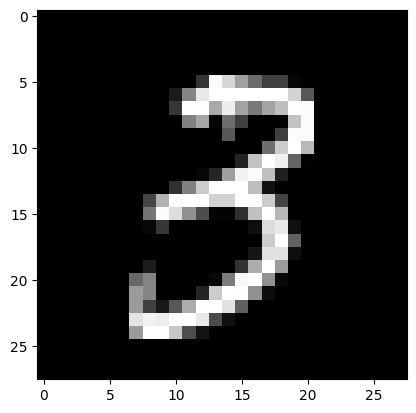

In [24]:
test_prediction(3, W1, b1, W2, b2)

In [25]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[7 9 6 8 7 7 4 0 3 2 0 1 3 2 3 8 4 6 0 1 2 0 2 0 1 3 8 7 3 9 5 6 7 8 3 8 5
 0 6 0 5 4 7 2 9 4 6 4 9 7 4 7 2 4 3 8 3 4 6 8 1 2 7 2 0 4 1 5 3 9 3 1 2 7
 6 6 7 2 8 6 4 9 3 1 4 1 4 5 9 9 5 4 9 9 6 2 1 8 4 1 3 3 7 1 1 2 7 4 1 7 8
 1 0 6 5 6 8 7 0 6 1 5 6 7 6 3 4 5 5 5 3 9 4 1 7 9 9 4 5 6 8 9 4 1 6 9 1 7
 8 9 1 9 7 2 6 8 7 3 4 6 5 4 6 0 9 9 1 4 2 8 6 5 3 2 2 4 3 6 1 2 6 0 3 3 4
 8 5 3 4 9 6 8 1 5 4 9 9 4 2 5 4 7 1 8 0 8 6 8 9 6 6 6 3 2 5 4 3 6 7 0 3 7
 6 3 0 2 9 9 7 8 9 1 7 8 5 0 6 4 4 2 7 3 4 2 4 4 1 9 1 0 7 6 1 7 3 3 0 6 1
 3 5 6 4 4 1 7 1 3 7 6 4 3 8 6 8 7 3 1 9 7 8 1 2 8 3 7 2 2 9 9 8 4 1 0 6 3
 9 9 2 0 5 8 7 0 4 3 4 9 7 0 7 2 9 4 7 9 9 0 6 0 2 6 7 0 5 3 0 8 7 4 7 0 7
 8 9 4 9 1 5 6 1 1 1 4 9 4 7 2 3 7 2 3 5 2 0 9 2 9 2 9 4 6 4 1 1 6 1 1 6 9
 5 3 9 1 8 1 5 9 6 7 6 7 4 6 9 0 8 1 9 5 4 5 9 5 9 5 9 9 4 8 3 2 5 9 3 6 6
 9 2 6 4 5 0 4 5 9 1 4 9 9 9 5 0 0 0 5 3 6 2 7 5 9 3 9 4 4 7 4 8 5 9 1 8 9
 8 9 4 6 3 7 8 3 1 7 0 6 3 2 8 0 2 2 1 7 7 1 9 6 3 5 6 4 9 9 0 0 7 2 2 6 1
 9 4 4 3 7 2 0 6 3 1 0 9 

0.839